スパースモデリング第15章　その他の応用
==
画像分離のための大域的MCA

In [3]:
from matplotlib.font_manager import FontProperties
from scipy.fftpack import dct, idct
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from skimage.io import imread
import pywt

font_path = u'/Library/Fonts/ヒラギノ角ゴ Pro W3.otf'
font_prop = FontProperties(fname=font_path)
plt.rc('font',family=font_prop.get_name())

def get_psnr(im, recon):
    """ PSNRを得る """ 
    return 10. * np.log(im.max() / np.sqrt(np.mean((im - recon) ** 2)))

def get_2D_dct(img):
    """ 2D DCT """
    return dct(dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coeffs):
    """ 2D inverse DCT """
    return idct(idct(coeffs.T, norm='ortho').T, norm='ortho')

Barbara
--

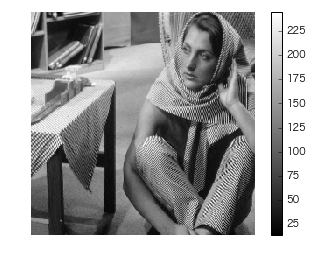

In [4]:
im = imread('barbara.png')[::2, ::2]

plt.imshow(im, cmap='gray', interpolation='Nearest')
plt.axis('off')
plt.colorbar()

縮小法
--

In [95]:
def wavelet_shrinkage(im, t, level, hard=False):
    """ ウェーブレット縮小 """
    Ds = []
    L = im.copy()
    for _ in range(level):
        L, D = pywt.dwt2(L, 'haar')
        if hard:
            D = np.where(np.abs(D) > t, D, 0)
        else:
            D = np.where(np.abs(D) > t, np.sign(D) * (np.abs(D) - t), 0)
        Ds.append(D)
    for l in range(level):
        L = pywt.idwt2((L, Ds[-(l + 1)]), 'haar')
    return L

def dct_shrinkage(im, t, patch_size=8, hard=False):
    """ DCT縮小 """
    patches = extract_patches_2d(im, (patch_size, patch_size))
    coeffs = get_2D_dct(patches)
    if hard:
        coeffs = np.where(np.abs(coeffs) > t, coeffs, 0)
    else:
        coeffs = np.where(np.abs(coeffs) > t, np.sign(coeffs) * (np.abs(coeffs) - t), 0)
    patches = get_2d_idct(coeffs)        
    return reconstruct_from_patches_2d(patches, im.shape)

画像分離のための大域的MCA
--

In [98]:
def global_mca(im, c=2., t=20., level=2, patch_size=8, n_iter=600):
    """ 画像分離のための大域的MCA """
    Y = im.copy()
    Y_c = np.zeros_like(Y) # content
    Y_t = np.zeros_like(Y) # texture

    for i in range(n_iter):
        Y_c_new = wavelet_shrinkage((Y - Y_c - Y_t) / c + Y_c, t, level)
        Y_t_new = dct_shrinkage((Y - Y_c - Y_t) / c + Y_t, t, patch_size=patch_size)
        opt = np.linalg.norm(Y_c_new - Y_c)
        opt2 = np.linalg.norm(Y_t_new - Y_t)
        Y_c = Y_c_new
        Y_t = Y_t_new
        if i % 10 == 0:
            print(i, opt, opt2)
            
    return Y_c, Y_t

Y_c_global_mca, Y_t_global_mca = global_mca(im)
Y_c_global_mca.tofile('Y_c_global_mca')
Y_t_global_mca.tofile('Y_t_global_mca')

0 16379.78511 16293.5228548
10 95.9281809282 88.0069151309
20 64.5270516656 62.3221806257
30 52.6485720484 51.3624475635
40 45.7251784885 44.7744874538
50 40.0964080101 39.2440279718
60 35.4594737852 34.8724279387
70 32.4911024354 32.1147935188
80 30.0938996452 29.653981747
90 27.5837270993 27.1943835484
100 24.8360117633 24.4379870202
110 22.6719642483 22.3830086751
120 21.0205469878 20.8037823475
130 19.5178082087 19.2069968506
140 17.9580309028 17.7445725166
150 16.9934233518 16.8422114448
160 15.9450983002 15.6830632172
170 14.9378844929 14.8165893703
180 14.2483101447 14.183659508
190 13.9267888917 13.870192349
200 12.9852648832 12.8669894819
210 12.6550217887 12.6314574461
220 12.5236546882 12.5000024804
230 12.3659005807 12.33580752
240 11.9420835403 11.9150482149
250 11.2835412221 11.2438095735
260 11.0958086967 11.0711025498
270 10.9680250008 10.9461536647
280 10.8421769557 10.8164503863
290 10.6537337818 10.6170803686
300 10.4613852747 10.4275040063
310 10.2809720796 10.25393

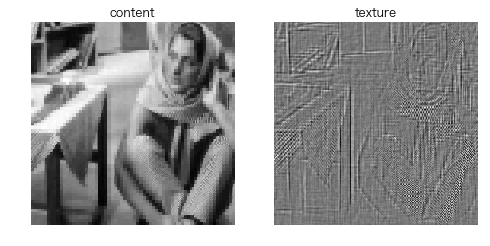

In [5]:
Y_c_global_mca = np.fromfile('Y_c_global_mca').reshape(im.shape)
Y_t_global_mca = np.fromfile('Y_t_global_mca').reshape(im.shape)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(Y_c_global_mca, cmap='gray', interpolation='Nearest')
ax[1].imshow(Y_t_global_mca, cmap='gray', interpolation='Nearest')
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('content')
ax[1].set_title('texture')
plt.savefig('global_mca.png', dpi=220)